In [6]:
df = pd.read_parquet('dataset.parquet', engine='pyarrow')

print(df)

           inst      bi   time  label
0        274560   29756    427      1
1        273975   29862    389      1
2        273510   29309    389      1
3        274614   29368    417      1
4        273029   29531    428      1
...         ...     ...    ...    ...
199995   827159  314966    336      0
199996     1916    1831  10270      0
199997   132652     125   1797      0
199998  4743522     575   4179      0
199999   277053     362    679      0

[200000 rows x 4 columns]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
import joblib

# Load the dataset
df = pd.read_parquet('dataset.parquet', engine='pyarrow')

# Split the dataset into features and labels
X = df[['inst', 'bi', 'time']]
y = df['label']

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Define a function to create the model
def create_model(activation1,activation2,activation3,activation4,activation5, optimizer, dropout):
    model = Sequential()
    model.add(Input(shape=(3,)))
    model.add(Dense(units=256, activation=activation1, kernel_initializer='glorot_uniform'))
    model.add(Dropout(rate=dropout))
    model.add(Dense(units=128, activation=activation2))
    model.add(Dropout(rate=dropout))
    model.add(Dense(units=64, activation=activation3))
    model.add(Dropout(rate=dropout))
    model.add(Dense(units=32, activation=activation4))
    model.add(Dropout(rate=dropout))
    model.add(Dense(units=16, activation=activation5))
    model.add(Dropout(rate=dropout))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the parameter grid
param_grid = {
    'batch_size': [100, 1024],
    'epochs': [100],
    'model__activation1': ['relu', 'tanh'],
    'model__activation2': ['relu', 'tanh'],
    'model__activation3': ['relu', 'tanh'],
    'model__activation4': ['relu', 'tanh'],
    'model__activation5': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout': [0.25,0.5]
}

# Wrap the Keras model with the KerasClassifier
model = KerasClassifier(
    model=create_model,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=0
)

# Perform grid search
gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1, return_train_score=True, verbose=0)
gs_result = gs.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid))

# Print the best parameters and the best score
print(f"Best Parameters: {gs_result.best_params_}")
print(f"Best Score: {gs_result.best_score_}")

best_model = gs_result.best_estimator_
accuracy = best_model.score(X_test_scaled, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

best_model.model_.save('nn_model.keras')
joblib.dump(scaler, 'scaler.joblib')

y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

df = pd.read_parquet('dataset.parquet', engine='pyarrow')

X = df[['inst', 'bi', 'time']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

model = Sequential()
model.add(Dense(32, input_shape=(3,), activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_valid_scaled, y_valid))

loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {accuracy:.4f}')





Epoch 1/50


5860/5860 [==============================] - 17s 3ms/step - loss: 0.3142 - accuracy: 0.8571 - val_loss: 0.1936 - val_accuracy: 0.9232
Epoch 2/50
5860/5860 [==============================] - 15s 3ms/step - loss: 0.1746 - accuracy: 0.9356 - val_loss: 0.1683 - val_accuracy: 0.9336
Epoch 3/50
5860/5860 [==============================] - 15s 3ms/step - loss: 0.1577 - accuracy: 0.9415 - val_loss: 0.1512 - val_accuracy: 0.9484
Epoch 4/50
5860/5860 [==============================] - 15s 3ms/step - loss: 0.1537 - accuracy: 0.9427 - val_loss: 0.1559 - val_accuracy: 0.9424
Epoch 5/50
5860/5860 [==============================] - 15s 3ms/step - loss: 0.1515 - accuracy: 0.9428 - val_loss: 0.1417 - val_accuracy: 0.9426
Epoch 6/50
5860/5860 [==============================] - 15s 3ms/step - loss: 0.1492 - accuracy: 0.9441 - val_loss: 0.1560 - val_accuracy: 0.9436
Epoch 7/50
5860/5860 [==============================] - 15s 3ms/step - loss: 0.1490 - accuracy: 0.9438 - val_loss: 0.1387 - v

Epoch 49/50
5860/5860 [==============================] - 22s 4ms/step - loss: 0.1280 - accuracy: 0.9528 - val_loss: 0.1174 - val_accuracy: 0.9572
Epoch 50/50
1954/1954 [==============================] - 5s 2ms/step - loss: 0.1278 - accuracy: 0.9543
Test Accuracy: 0.9543


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import joblib

df = pd.read_parquet('dataset.parquet', engine='pyarrow')

X = df[['inst', 'bi', 'time']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

model = Sequential()
model.add(Input(shape=(3,)))

model.add(Dense(64, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(16, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_valid_scaled, y_valid), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test_scaled, y_test)

print(f'Test Accuracy: {accuracy:.4f}')

model.save('nn_model.keras')

joblib.dump(scaler, 'scaler.joblib')


Epoch 1/50
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7155 - loss: 0.5548 - val_accuracy: 0.8711 - val_loss: 0.3082
Epoch 2/50
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8724 - loss: 0.3215 - val_accuracy: 0.8832 - val_loss: 0.2721
Epoch 3/50
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8854 - loss: 0.2949 - val_accuracy: 0.9071 - val_loss: 0.2234
Epoch 4/50
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8910 - loss: 0.2828 - val_accuracy: 0.9074 - val_loss: 0.2234
Epoch 5/50
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8956 - loss: 0.2732 - val_accuracy: 0.9079 - val_loss: 0.2188
Epoch 6/50
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8977 - loss: 0.2677 - val_accuracy: 0.9195 - val_loss: 0.1982
Epoch 7/50
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8999 - loss: 0.2642 - val_accuracy: 0.9167 - val_loss: 0.2038
Epoch 8/50
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9013 - loss: 0

['scaler.joblib']

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import joblib

def nnclassifier(parquet_path):
    model = load_model('nn_model.keras')
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    scaler = joblib.load('scaler.joblib')
    
    dataset = pd.read_parquet(parquet_path)
    
    X_new = dataset[['inst', 'bi', 'time']]
    
    new_data_scaled = scaler.transform(X_new)
    
    predictions = model.predict(new_data_scaled)
    
    prediction_classes = (predictions > 0.5).astype("int32")
    
    return prediction_classes

parquet_path = 'teste.parquet'
predicted_classes = nnclassifier(parquet_path)

print(predicted_classes)


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
[[0]
 [1]
 [0]
 ...
 [1]
 [0]
 [1]]


In [3]:
df = pd.read_parquet('teste.parquet', engine='pyarrow')

lab = df['label']

print (lab)

0        0
1        1
2        0
3        0
4        0
        ..
99995    1
99996    0
99997    0
99998    0
99999    1
Name: label, Length: 100000, dtype: int64


In [7]:
import numpy as np
import pandas as pd

true_values = lab.values

predictions_flat = predicted_classes.flatten()

comparison = predictions_flat == true_values

acc = 0
for i in (comparison):
    if i:
        acc = acc+1
    
accuracy = (acc / len(true_values))

print (accuracy)

print(comparison)

0.80411
[ True  True  True ... False  True  True]


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop
##from keras.optimizers import Adam
import joblib

df = pd.read_parquet('dataset.parquet', engine='pyarrow')

X = df[['inst', 'bi', 'time']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)


model = Sequential()
model.add(Input(shape=(3,)))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

optimizer = RMSprop(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_valid_scaled, y_valid), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test_scaled, y_test)

print(f'Test Accuracy: {accuracy:.4f}')

model.save('nn_model.keras')

joblib.dump(scaler, 'scaler.joblib')




Epoch 1/50
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8136 - loss: 0.4134 - val_accuracy: 0.9010 - val_loss: 0.2657
Epoch 2/50
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8978 - loss: 0.2802 - val_accuracy: 0.9147 - val_loss: 0.2638
Epoch 3/50
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8947 - loss: 0.2817 - val_accuracy: 0.9229 - val_loss: 0.2065
Epoch 4/50
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9042 - loss: 0.2645 - val_accuracy: 0.9191 - val_loss: 0.2206
Epoch 5/50
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9030 - loss: 0.2671 - val_accuracy: 0.9114 - val_loss: 0.2363
Epoch 6/50
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9053 - loss: 0.2615 - val_accuracy: 0.9096 - val_loss: 0.2366
Epoch 7/50
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9065 - loss: 0.2566 - val_accuracy: 0.9267 - val_loss: 0.2343
Epoch 8/50
5860/5860 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9090 - loss: 0

['scaler.joblib']

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import joblib

df = pd.read_parquet('dataset.parquet', engine='pyarrow')

X = df[['inst', 'bi', 'time']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

model = Sequential()
model.add(Input(shape=(3,)))

model.add(Dense(256, activation='tanh'))

model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(128, activation='tanh'))

model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(16, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
##reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=1024, validation_data=(X_valid_scaled, y_valid), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test_scaled, y_test)

print(f'Test Accuracy: {accuracy:.4f}')

model.save('nn_model.keras')

joblib.dump(scaler, 'scaler.joblib')


Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6059 - loss: 0.7756 - val_accuracy: 0.5011 - val_loss: 1.7715
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7496 - loss: 0.4988 - val_accuracy: 0.5011 - val_loss: 2.2177
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8842 - loss: 0.3061 - val_accuracy: 0.5011 - val_loss: 2.8927
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9070 - loss: 0.2595 - val_accuracy: 0.5011 - val_loss: 3.1281
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9146 - loss: 0.2432 - val_accuracy: 0.4157 - val_loss: 3.0925
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9193 - loss: 0.2289 - val_accuracy: 0.4384 - val_loss: 2.4954
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9191 - loss: 0.2280 - val_accuracy: 0.6995 - val_loss: 0.6542
Epoch 8/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9220 - loss: 0.2205 - 

['scaler.joblib']

Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6102 - loss: 8.3690 - val_accuracy: 0.4989 - val_loss: 1.0554
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8979 - loss: 0.4973 - val_accuracy: 0.5011 - val_loss: 0.8182
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9109 - loss: 0.3037 - val_accuracy: 0.5011 - val_loss: 0.6990
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9152 - loss: 0.2816 - val_accuracy: 0.7562 - val_loss: 0.4641
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9179 - loss: 0.2732 - val_accuracy: 0.8926 - val_loss: 0.2653
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9165 - loss: 0.2711 - val_accuracy: 0.4898 - val_loss: 3.2480
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9198 - loss: 0.2652 - val_accuracy: 0.4771 - val_loss: 1.6769
Epoch 8/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9211 - loss: 0.2569 -

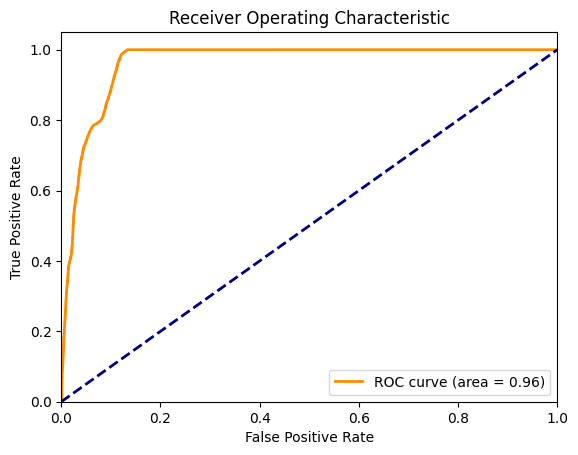

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
import joblib

df = pd.read_parquet('dataset.parquet', engine='pyarrow')

X = df[['inst', 'bi', 'time']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

l2_reg = 0.05
model = Sequential()
model.add(Input(shape=(3,)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=1024, validation_data=(X_valid_scaled, y_valid), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

model.save('nn_model.keras')
joblib.dump(scaler, 'scaler.joblib')

y_pred_prob = model.predict(X_test_scaled).ravel()

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
import joblib

df = pd.read_parquet('dataset.parquet', engine='pyarrow')

X = df[['inst', 'bi', 'time']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

l2_reg = 0.05

model = Sequential()
model.add(Input(shape=(3,)))

model.add(Dense(256, activation='tanh', kernel_regularizer=l2(l2_reg)))

model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(128, activation='tanh', kernel_regularizer=l2(l2_reg)))

model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='tanh', kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu', kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
##reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=1024, validation_data=(X_valid_scaled, y_valid), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test_scaled, y_test)

print(f'Test Accuracy: {accuracy:.4f}')

model.save('nn_model.keras')

joblib.dump(scaler, 'scaler.joblib')


Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6351 - loss: 9.7861 - val_accuracy: 0.5011 - val_loss: 1.3865
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9008 - loss: 0.7145 - val_accuracy: 0.5011 - val_loss: 0.9340
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9166 - loss: 0.3226 - val_accuracy: 0.5011 - val_loss: 0.9057
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9180 - loss: 0.2838 - val_accuracy: 0.6404 - val_loss: 0.5595
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9156 - loss: 0.2828 - val_accuracy: 0.7980 - val_loss: 0.4023
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9204 - loss: 0.2670 - val_accuracy: 0.7542 - val_loss: 0.5450
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9174 - loss: 0.2721 - val_accuracy: 0.7310 - val_loss: 0.4978
Epoch 8/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9204 - loss: 0.2610 -

['scaler.joblib']